This file implements [this](https://github.com/AmritSd/Institutional-ownership-impact-on-stocks-near-one-dollar/issues/7) function

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import statsmodels.api as sm

In [2]:
price_data_file = '../data/merged_price_instit_data.pkl'
three_factor_file = '../data/fama_french_factor_lagged.pkl'

price_data = pd.read_pickle(price_data_file).dropna(subset=['date'])
three_factor_data = pd.read_pickle(three_factor_file)

three_factor_data['Mkt-RF'] = three_factor_data['Mkt-RF'] / 100
three_factor_data['SMB'] = three_factor_data['SMB'] / 100
three_factor_data['HML'] = three_factor_data['HML'] / 100
three_factor_data['RF'] = three_factor_data['RF'] / 100
three_factor_data['Mkt-RF_lag1'] = three_factor_data['Mkt-RF_lag1'] / 100
three_factor_data['SMB_lag1'] = three_factor_data['SMB_lag1'] / 100
three_factor_data['HML_lag1'] = three_factor_data['HML_lag1'] / 100

In [3]:
display(price_data)
display(three_factor_data)

,PERMNO,date,EXCHCD,SICCD,TICKER,TRDSTAT,CUSIP,DLSTCD,DLRET,PRC,RET,SHROUT,cusip,fdate,shares,institutional_ownership_perc
11861,14945,2014-12-31,1.0,6799,AAC,A,00030710,NaN,NaN,30.92,-0.001292,21081000.0,00030710,2014-12-31,2954597.0,0.140154
11862,14945,2015-01-02,1.0,6799,AAC,A,00030710,NaN,NaN,30.21,-0.022963,21081000.0,00030710,2015-01-02,2954597.0,0.140154
11863,14945,2015-01-05,1.0,6799,AAC,A,00030710,NaN,NaN,29.73,-0.015889,21081000.0,00030710,2015-01-05,2954597.0,0.140154
11864,14945,2015-01-06,1.0,6799,AAC,A,00030710,NaN,NaN,29.38,-0.011773,21081000.0,00030710,2015-01-06,2954597.0,0.140154
11865,14945,2015-01-07,1.0,6799,AAC,A,00030710,NaN,NaN,28.64,-0.025187,21081000.0,00030710,2015-01-07,2954597.0,0.140154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14332861,15857,2021-12-27,3.0,9999.0,WVE,A,Y9530810,NaN,NaN,3.50,-0.054054,51998000.0,Y9530810,2021-12-27,30737458.0,0.591128
14332862,15857,2021-12-28,3.0,9999.0,WVE,A,Y9530810,NaN,NaN,3.30,-0.057143,51998000.0,Y9530810,2021-12-28,30737458.0,0.591128
14332863,15857,2021-12-29,3.0,9999.0,WVE,A,Y9530810,NaN,NaN,3.25,-0.015152,51998000.0,Y9530810,2021-12-29,30737458.0,0.591128
14332864,15857,2021-12-30,3.0,9999.0,WVE,A,Y9530810,NaN,NaN,3.28,0.009231,51998000.0,Y9530810,2021-12-30,30737458.0,0.591128


,date,Mkt-RF,SMB,HML,RF,Mkt-RF_lag1,SMB_lag1,HML_lag1
1,1926-07-02,0.0045,-0.0033,-0.0006,0.00009,0.0010,-0.0025,-0.0027
2,1926-07-06,0.0017,0.0030,-0.0039,0.00009,0.0045,-0.0033,-0.0006
3,1926-07-07,0.0009,-0.0058,0.0002,0.00009,0.0017,0.0030,-0.0039
4,1926-07-08,0.0021,-0.0038,0.0019,0.00009,0.0009,-0.0058,0.0002
5,1926-07-09,-0.0071,0.0043,0.0057,0.00009,0.0021,-0.0038,0.0019
...,...,...,...,...,...,...,...,...
25394,2022-12-23,0.0051,-0.0060,0.0115,0.00016,-0.0152,0.0010,0.0037
25395,2022-12-27,-0.0051,-0.0073,0.0142,0.00016,0.0051,-0.0060,0.0115
25396,2022-12-28,-0.0123,-0.0025,-0.0029,0.00016,-0.0051,-0.0073,0.0142
25397,2022-12-29,0.0187,0.0127,-0.0107,0.00016,-0.0123,-0.0025,-0.0029


In [4]:
def regress_three_factors(price_data, three_factor_data):
    # Merge on date
    merged_data = price_data.merge(three_factor_data, on='date', how='left')
    merged_data = merged_data.dropna(subset=['RET', 'RF', 'Mkt-RF', 'SMB', 'HML', 'Mkt-RF_lag1', 'SMB_lag1', 'HML_lag1'])

    y = merged_data['RET'].astype(float) - merged_data['RF']
    # Add a constant to the X data

    X = merged_data[['Mkt-RF', 'SMB', 'HML', 'Mkt-RF_lag1', 'SMB_lag1', 'HML_lag1']].copy()
    X['constant'] = 1

    
    model = sm.OLS(y, X)

    results = model.fit()

    # return mktrf + mktrf_lag1, smb + smb_lag1, hml + hml_lag1
    
    return results.params[0] + results.params[3], results.params[1] + results.params[4], results.params[2] + results.params[5]



In [5]:
def calc_returns(stock_returns, mkt_data, smb_data, hml_data, rf_data,  beta_mktrf, beta_smb, beta_hml):
    stock_returns = np.array(stock_returns)
    mkt_data = np.array(mkt_data)
    smb_data = np.array(smb_data)
    hml_data = np.array(hml_data)

    # Calculate the alpha
    alpha = stock_returns - rf_data - beta_mktrf * mkt_data - beta_smb * smb_data - beta_hml * hml_data

    final_ret = np.prod(1 + alpha) - 1

    return final_ret

In [14]:
def detect_price_dips(single_stock_price_data, three_factor_data, threshold, visualize=False):
    """
    Detects whenever a stock price dips below a given threshold and calculates the 
    30-day, 90-day, and 180-day returns from that point on.

    Args:
        single_stock_price_data (pandas.DataFrame): Stock price data with columns 'date' and 'PRC'
        three_factor_data (pandas.DataFrame): Three factor Fama French returns with lagged factors as well.
        threshold (float): Price threshold

    Returns:
        An array containing the trades made.
        Each trade will be a dictionary
        The dictionary will contain the starting date, institutional ownership percentage, permno, cusip
        a returns dictionary containing the 30-day, 90-day, and 180-day returns, and a alphas dictionaries containing the 30-day, 90-day, and 180-day alphas
    """
    trades = []
    # Make three_factor_data decimal instead of percentage


    # State 0: Above price threshold
    # State 1: Below price threshold

    state = 1
    in_trade = False

    returns = []
    mkt_returns = []
    smb_returns = []
    hml_returns = []
    rf_returns = []

    trade = None

    beta_mktrf, beta_smb, beta_hml = (0, 0, 0)

    # Since we want atleast one year of price data for the three factor regression, we start at year 2
    start_date = single_stock_price_data.iloc[0]['date']
    start_date_plus_one_year = start_date + pd.Timedelta(days=365)

    for index, row in single_stock_price_data[single_stock_price_data['date'] >= start_date_plus_one_year].iterrows():
        price = row['PRC']
        date = row['date']
        ret = row['RET']
        trading_status = row['TRDSTAT']

        try:
            delisting_return = float(row['DLRET'])
        except:
            delisting_return = float('nan')

        if(not in_trade and state != 0 and price >= threshold):
            state = -1
        if(not in_trade and state == -1 and price < threshold and trading_status == 'A'):
            state = 0
        
        if(state == 0 and date.day == 1):
            state = 1 # Buy
            in_trade = True
            trade = {}
            trade['start_date'] = date
            trade['institutional_ownership'] = row['institutional_ownership_perc']
            trade['permno'] = row['PERMNO']
            trade['cusip'] = row['CUSIP']
            trade['returns'] = {}
            trade['alphas'] = {}
            beta_mktrf, beta_smb, beta_hml = regress_three_factors(single_stock_price_data[single_stock_price_data['date'] < date], three_factor_data)
        
        elif(in_trade):
            returns.append(ret)
            mkt_returns.append(three_factor_data[three_factor_data['date'] == date]['Mkt-RF'].iloc[0])
            smb_returns.append(three_factor_data[three_factor_data['date'] == date]['SMB'].iloc[0])
            hml_returns.append(three_factor_data[three_factor_data['date'] == date]['HML'].iloc[0])
            rf_returns.append(three_factor_data[three_factor_data['date'] == date]['RF'].iloc[0])

                
            if(not math.isnan(delisting_return)):
                # Stock got delisted so we need to close the trade
                returns[-1] = (1 + float(returns[-1])) * (1 + delisting_return) - 1
                np_ret = np.array(returns).astype(float)
                trade['returns']['180'] = np.prod(np_ret + 1) - 1
                trade['returns']['180-end'] = date

                trade['alphas']['180'] = calc_returns(np_ret, mkt_returns, smb_returns, hml_returns, rf_returns, beta_mktrf, beta_smb, beta_hml)


                # Close the trade
                if('90' not in trade['returns']):
                    trade['returns']['90'] = trade['returns']['180']
                    trade['returns']['90-end'] = date
                    trade['alphas']['90'] = trade['alphas']['180']
                
                if('30' not in trade['returns']):
                    trade['returns']['30'] = trade['returns']['180']
                    trade['returns']['30-end'] = date
                    trade['alphas']['30'] = trade['alphas']['180']
                
                in_trade = False
                returns = []
                mkt_returns = []
                smb_returns = []
                hml_returns = []
                rf_returns = []
                trades.append(trade)
                trade = None

            elif(date >= trade['start_date'] + pd.Timedelta(days=180) and trading_status == 'A'):
                np_ret = np.array(returns).astype(float)
                trade['returns']['180'] = np.prod(np_ret + 1) - 1
                trade['returns']['180-end'] = date

                trade['alphas']['180'] = calc_returns(np_ret, mkt_returns, smb_returns, hml_returns, rf_returns, beta_mktrf, beta_smb, beta_hml)

                # Close the trade
                if('90' not in trade['returns']):
                    trade['returns']['90'] = trade['returns']['180']
                    trade['returns']['90-end'] = date
                    trade['alphas']['90'] = trade['alphas']['180']

                if('30' not in trade['returns']):
                    trade['returns']['30'] = trade['returns']['180']
                    trade['returns']['30-end'] = date
                    trade['alphas']['30'] = trade['alphas']['180']

                in_trade = False
                returns = []
                mkt_returns = []
                smb_returns = []
                hml_returns = []
                rf_returns = []
                trades.append(trade)
                trade = None
                
            elif(date >= trade['start_date'] + pd.Timedelta(days=90) and '90' not in trade['returns'] and trading_status == 'A'):
                np_ret = np.array(returns).astype(float)
                trade['returns']['90'] = np.prod(np_ret + 1) - 1
                trade['returns']['90-end'] = date

                trade['alphas']['90'] = calc_returns(np_ret, mkt_returns, smb_returns, hml_returns, rf_returns, beta_mktrf, beta_smb, beta_hml)

                if('30' not in trade['returns']):
                    trade['returns']['30'] = trade['returns']['90']
                    trade['returns']['30-end'] = date

                    trade['alphas']['30'] = trade['alphas']['90']


            elif(date >= trade['start_date'] + pd.Timedelta(days=30) and '30' not in trade['returns'] and trading_status == 'A'):
                np_ret = np.array(returns).astype(float)
                trade['returns']['30'] = np.prod(np_ret + 1) - 1
                trade['returns']['30-end'] = date

                trade['alphas']['30'] = calc_returns(np_ret, mkt_returns, smb_returns, hml_returns, rf_returns, beta_mktrf, beta_smb, beta_hml)



    

    if(visualize):
        visualize_trades(single_stock_price_data, trades, threshold)

    return trades


def visualize_trades(single_stock_price_data, trades, threshold):
    plt.figure(figsize=(30,10))
    plt.title('Ticker: {}'.format(single_stock_price_data['TICKER'].iloc[0]), fontsize=20)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.plot(single_stock_price_data['date'], single_stock_price_data['PRC'])

    for trade in trades:
        # plt.axvline(x=trade['start_date'], color='g')

        # visualize returns
        if('returns' in trade):
            st = trade['start_date']

            p_1 = st + pd.Timedelta(days=30)
            if('30-end' in trade['returns']):
                p_1 = trade['returns']['30-end']
            
            p_2 = p_1 + pd.Timedelta(days=90)
            if('90-end' in trade['returns']):
                p_2 = trade['returns']['90-end']

            p_3 = p_2 + pd.Timedelta(days=90)
            if('180-end' in trade['returns']):
                p_3 = trade['returns']['180-end']


            
            if('30' in trade['returns']):
                plt.axvspan(st, p_1, color='g', alpha=0.2)
                plt.annotate('30-day ret\n{:.2f}% \nalpha\n{:.2f}'.format(trade['returns']['30'] * 100, trade['alphas']['30'] * 100), xy=(p_1,  threshold * 1.3), xytext=(p_1, threshold * 1.6), arrowprops=dict(facecolor='green', shrink=0.05))
            if('90' in trade['returns']):
                plt.axvspan(p_1, p_2, color='b', alpha=0.2)
                plt.annotate('90-day ret\n{:.2f} \nalpha\n{:.2f}%'.format(trade['returns']['90'] * 100, trade['alphas']['90'] * 100), xy=(p_2, threshold * 1.6), xytext=(p_2, threshold * 1.9), arrowprops=dict(facecolor='blue', shrink=0.05))

            if('180' in trade['returns']):
                plt.axvspan(p_2, p_3, color='r', alpha=0.2)
                plt.annotate('180-day ret\n{:.2f}% \nalpha\n{:.2f}%'.format(trade['returns']['180'] * 100, trade['alphas']['180'] * 100), xy=(p_3, threshold * 2), xytext=(p_3, threshold * 2.3), arrowprops=dict(facecolor='red', shrink=0.05))

   # Draw price threshold, thin line
    plt.axhline(y=threshold, color='r', linestyle='--', alpha=0.5, label='Price Threshold {:.2f}'.format(threshold), linewidth=2)

    # Highlight areas where TRDSTAT is not A
    not_a = single_stock_price_data[single_stock_price_data['TRDSTAT'] != 'A']

    # Merge consecutive rows using index
    spans = []
    span_start = None
    span_end = None
    for index, row in not_a.iterrows():
        if(span_start == None):
            span_start = index
            span_end = index
        elif(index == span_end + 1):
            span_end = index
        else:
            spans.append((span_start, span_end))
            span_start = index
            span_end = index

    if(span_start != None):
        spans.append((span_start, span_end))


    for span in spans:
        start_date = single_stock_price_data.loc[span[0]]['date']
        end_date = single_stock_price_data.loc[span[1]]['date']
        plt.axvspan(start_date, end_date, color='r', alpha=0.2)
        # Print TRDSTAT on the graph in the middle of the span
        plt.annotate('Trading status : {}'.format(single_stock_price_data.loc[span[0]]['TRDSTAT']), xy=(start_date + (end_date - start_date) / 2, threshold * 1.1), xytext=(start_date + (end_date - start_date) / 2, threshold * 1.4), arrowprops=dict(facecolor='red', shrink=0.05))



In [15]:
permnos = price_data['PERMNO'].unique()

all_trades = []

for permno in permnos:
    price_data_of_interest = price_data[price_data['PERMNO'] == permno]
    trades = detect_price_dips(price_data_of_interest, three_factor_data, 5, visualize=False)
    all_trades.extend(trades)

print(len(all_trades))


7644


In [16]:
# Make a df out of allTrades with columns startDate, ownershipPerc, 30, 90, 180, cusip, tic
all_trades_df = pd.DataFrame(all_trades)
# Unwrap the returns column with dict keys as columns and dict values as values
all_trades_df = pd.concat([all_trades_df.drop(['returns'], axis=1), all_trades_df['returns'].apply(pd.Series)], axis=1)
# Rename 30 to return_30
all_trades_df = all_trades_df.rename(columns={'30': 'return_30'})
# Rename 90 to return_90
all_trades_df = all_trades_df.rename(columns={'90': 'return_90'})
# Rename 180 to return_180
all_trades_df = all_trades_df.rename(columns={'180': 'return_180'})

# Unwrap the alphas column with dict keys as columns and dict values as values
all_trades_df = pd.concat([all_trades_df.drop(['alphas'], axis=1), all_trades_df['alphas'].apply(pd.Series)], axis=1)
# Rename 30 to alpha_30
all_trades_df = all_trades_df.rename(columns={'30': 'alpha_30'})
# Rename 90 to alpha_90
all_trades_df = all_trades_df.rename(columns={'90': 'alpha_90'})
# Rename 180 to alpha_180
all_trades_df = all_trades_df.rename(columns={'180': 'alpha_180'})

# Bin trades
all_trades_df['institutional_ownership_bin'] = pd.cut(all_trades_df['institutional_ownership'], [0, 0.2, 0.4, 0.6, 0.8, 1], labels=['0-20%', '20-40%', '40-60%', '60-80%', '80+'])
# # Drop nan values
# allTradesDfDroppedNan = allTradesDf
# allTradesDfDroppedNan = allTradesDfDroppedNan[allTradesDfDroppedNan['30'] < 10]

display(all_trades_df)
# Print the mean and median for each bin for the returns as a table
# display(all_trades_df.groupby('institutional_ownership_bin').agg({'30': ['mean', 'median'], '90': ['mean', 'median'], '180': ['mean', 'median']}))

# write df to pickle
all_trades_df.to_pickle('../data/all_trades_at_5_buy_next_month.pkl')



,start_date,institutional_ownership,permno,cusip,return_30,30-end,return_90,90-end,return_180,180-end,alpha_30,alpha_90,alpha_180,institutional_ownership_bin
0,2019-02-01,0.291140,14945,00030710,0.040983,2019-03-04 00:00:00,-0.336064,2019-05-02 00:00:00,-0.597131,2019-07-31 00:00:00,-0.048627,-0.384616,-0.621009,20-40%
1,2008-12-01,0.503035,90825,00081T10,2.631581,2008-12-31 00:00:00,0.599998,2009-03-02 00:00:00,2.610544,2009-06-01 00:00:00,2.178656,0.882505,2.266139,40-60%
2,2010-07-01,0.488968,90825,00081T10,0.238748,2010-08-02 00:00:00,0.144812,2010-09-29 00:00:00,0.704499,2010-12-28 00:00:00,0.181233,0.144100,0.342840,40-60%
3,2011-11-01,0.637308,90825,00081T10,0.428353,2011-12-01 00:00:00,0.608632,2012-01-30 00:00:00,0.625583,2012-04-30 00:00:00,0.407333,0.406147,0.452294,60-80%
4,2020-04-01,0.747115,90825,00081T10,0.515992,2020-05-01 00:00:00,0.530018,2020-06-30 00:00:00,0.324989,2020-09-28 00:00:00,0.244177,0.065435,-0.055570,60-80%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7639,2016-02-01,0.422057,81784,Y8564W10,0.180351,2016-03-02 00:00:00,0.564563,2016-05-02 00:00:00,-0.158865,2016-08-01 00:00:00,0.131970,0.384036,-0.293787,40-60%
7640,2019-02-01,0.141747,81784,Y8564W10,0.144068,2019-03-04 00:00:00,0.220340,2019-05-02 00:00:00,0.288139,2019-07-31 00:00:00,0.087857,0.117542,0.173171,0-20%
7641,2020-04-01,0.140701,81784,Y8564W10,0.165562,2020-05-01 00:00:00,-0.205297,2020-06-30 00:00:00,-0.278144,2020-09-28 00:00:00,-0.089378,-0.468178,-0.565120,0-20%
7642,2016-02-01,0.405488,91656,Y8565J10,-0.079569,2016-03-02 00:00:00,0.420558,2016-05-02 00:00:00,0.280088,2016-08-01 00:00:00,-0.105227,0.292213,0.111880,40-60%


In [17]:
# agg by bin
agg_by_bin = all_trades_df.groupby('institutional_ownership_bin').agg({'return_30': ['mean', 'median'], 'return_90': ['mean', 'median'], 'return_180': ['mean', 'median']})

agg_by_bin_alphas = all_trades_df.groupby('institutional_ownership_bin').agg({'alpha_30': ['mean', 'median'], 'alpha_90': ['mean', 'median'], 'alpha_180': ['mean', 'median']})

display(agg_by_bin)
display(agg_by_bin_alphas)

return_30           return_90            \
                                 mean    median      mean    median   
institutional_ownership_bin                                           
0-20%                        0.036137  0.006705  0.057488 -0.002000   
20-40%                       0.056098  0.010870  0.074268  0.013484   
40-60%                       0.080525  0.033899  0.099565  0.028507   
60-80%                       0.135711  0.065814  0.171006  0.050849   
80+                          0.110988  0.017819  0.083719  0.006327   

                            return_180            
                                  mean    median  
institutional_ownership_bin                       
0-20%                         0.117471  0.018511  
20-40%                        0.165249  0.038886  
40-60%                        0.229920  0.087049  
60-80%                        0.320822  0.131750  
80+                           0.266948  0.039291

alpha_30            alpha_90           alpha_180  \
                                 mean    median      mean    median      mean   
institutional_ownership_bin                                                     
0-20%                       -0.001421 -0.016747 -0.004410 -0.040069 -0.009610   
20-40%                       0.006201 -0.017085  0.009539 -0.030139  0.014571   
40-60%                       0.023585 -0.006106  0.038674 -0.012794  0.062901   
60-80%                       0.040685  0.002421  0.055231 -0.044064  0.104363   
80+                          0.025370 -0.024841  0.026911 -0.044531  0.065179   

                                       
                               median  
institutional_ownership_bin            
0-20%                       -0.068682  
20-40%                      -0.057175  
40-60%                      -0.022550  
60-80%                      -0.040746  
80+                         -0.071431

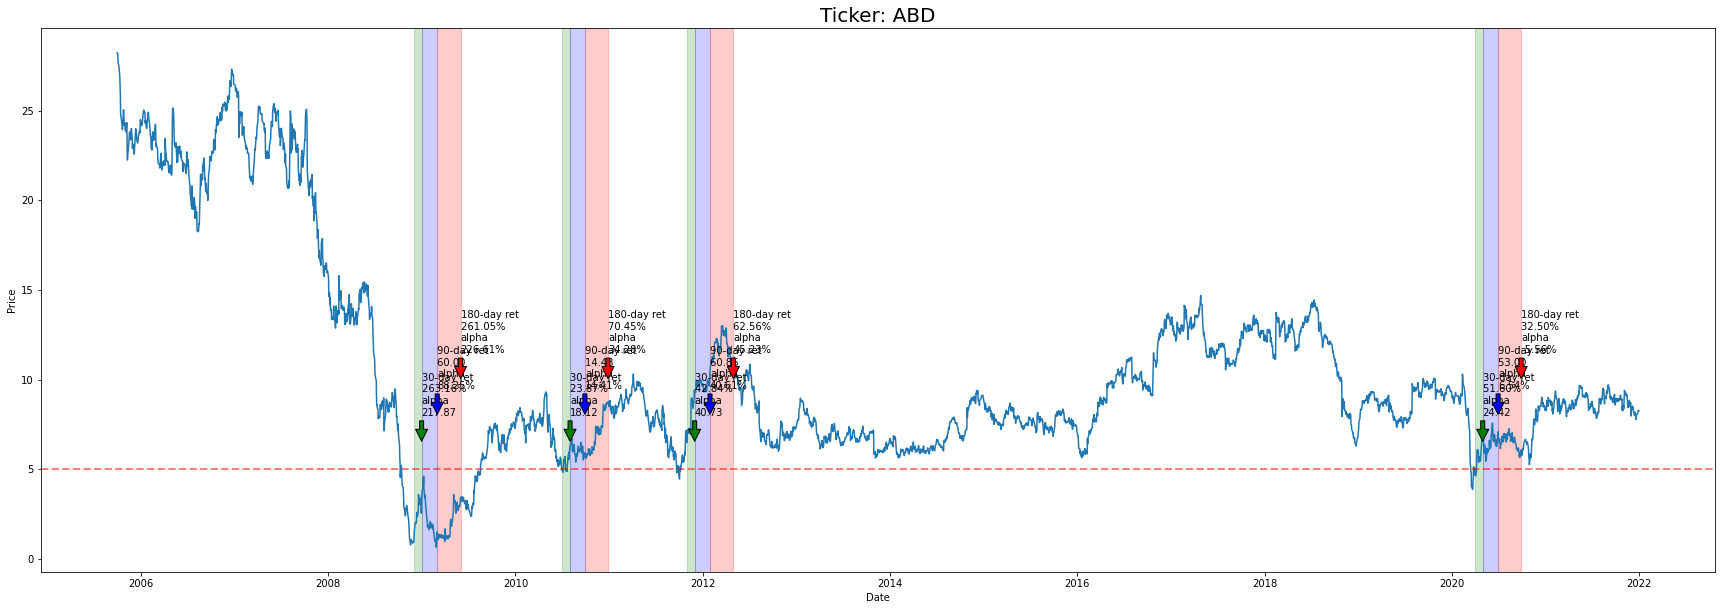

In [19]:
# permno of interest
permno_of_interest = 90825

price_data_of_interest = price_data[price_data['PERMNO'] == permno_of_interest]
trades = detect_price_dips(price_data_of_interest, three_factor_data, 5, visualize=True)

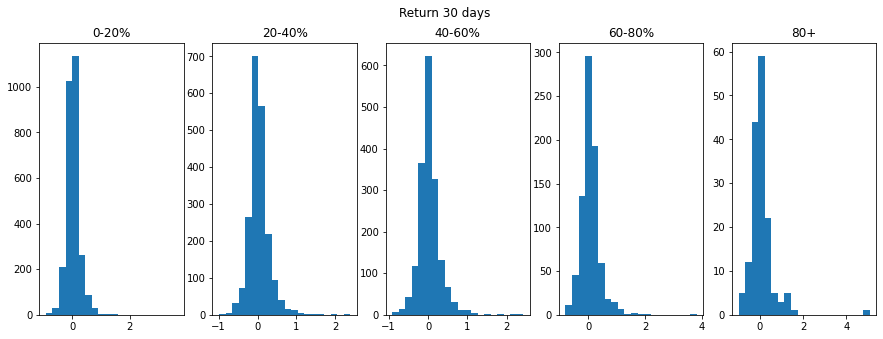

In [10]:
# Plot hist of returns for each bin
fig, ax = plt.subplots(1, 5, figsize=(15, 5))
ax[0].hist(all_trades_df[all_trades_df['institutional_ownership_bin'] == '0-20%']['return_30'], bins=20)
ax[0].set_title('0-20%')
ax[1].hist(all_trades_df[all_trades_df['institutional_ownership_bin'] == '20-40%']['return_30'], bins=20)
ax[1].set_title('20-40%')
ax[2].hist(all_trades_df[all_trades_df['institutional_ownership_bin'] == '40-60%']['return_30'], bins=20)
ax[2].set_title('40-60%')
ax[3].hist(all_trades_df[all_trades_df['institutional_ownership_bin'] == '60-80%']['return_30'], bins=20)
ax[3].set_title('60-80%')
ax[4].hist(all_trades_df[all_trades_df['institutional_ownership_bin'] == '80+']['return_30'], bins=20)
ax[4].set_title('80+')

fig.suptitle('Return 30 days')
plt.show()